#### EMACS LISP STUFF PLEASE IGNORE
(defun switch-to-notebook ()
 (interactive)
 (st-toggle-to-buffer "*ein: http://127.0.0.1:8899/make_figs.ipynb*"))

In [1]:
%pylab inline
import os,sys
from importlib import reload
from copy import deepcopy
plt.style.use("default")
plt.rcParams["figure.figsize"] = (8,3)
from matplotlib.gridspec import GridSpec
from scipy.signal import stft
from builtins import sum as bsum

Populating the interactive namespace from numpy and matplotlib


In [2]:
import units; reload(units); UNITS = units.UNITS

In [16]:
import boulder;   reload(boulder)
import crick;     reload(crick)
import surrogate; reload(surrogate)
import fisher_plumes_tools as fpt;      reload(fpt)
import fisher_plumes_figs  as fpf;      reload(fpf);
import fisher_plumes_fig_tools as fpft; reload(fpft)
import fisher_plumes as fp;             reload(fp)
import utils; reload(utils)
FisherPlumes = fp.FisherPlumes

force_reload = False
n_bootstraps = 10

crick.logger.setLevel(logging.DEBUG)

if force_reload or ('Fbw1' not in locals()):
    pairs_mode = "unsigned"
    # Fbw = FisherPlumes("boulder16", pitch = 25000 * UNITS.um,  freq_max = 20 * UNITS.hertz,
    #                    which_coords = [(0.45, 0.5),
    #                                    #(0.35,0.5),
    #                                    #(0.25,0.5),
    #                                    #(0.15,0.5)
    #                                    ]*UNITS.m,
    #                    py_mode = "relative",
    #                    suffix='manuscript',
    #                    pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
    # Fcr = FisherPlumes("n12dishT",  pitch = 76000 * UNITS.um, freq_max = 100 * UNITS.hertz,
    #                    which_coords = [(1.0, 0.5),
    #                                    #(0.9,0.5),
    #                                    (0.7,0.5),
    #                                    #(0.6,0.5)
    #                                    ]*UNITS.m,
    #                    pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)
    Fsu = FisherPlumes("surr_no_info",
                       freq_max = 100 * UNITS.hertz,
                       pitch = 0.1 * UNITS.m,
                       which_coords = [(1.0, 0.)]*UNITS.m,
                       pairs_mode = pairs_mode, n_bootstraps = n_bootstraps, random_seed = 0)    
else:
    Fbw = FisherPlumes(Fbw)
#    Fcr = FisherPlumes(Fcr)
    Fsu = FisherPlumes(Fsu)
data = {
#    "cr":Fcr,
    "bw":Fbw,
    "su":Fsu
}

INFO:boulder:Boulder simulation data available for:


INFO:boulder:Re100_0_5mm_50Hz_16source_manuscript.h5         : ['Odor Data/c1a', 'Odor Data/c1b', 'Odor Data/c2a', 'Odor Data/c2b', 'Odor Data/c3a', 'Odor Data/c3b', 'Odor Data/c4a', 'Odor Data/c4b', 'Odor Data/c5a', 'Odor Data/c5b', 'Odor Data/c6a', 'Odor Data/c6b', 'Odor Data/c7a', 'Odor Data/c7b', 'Odor Data/c8a', 'Odor Data/c8b'] (16 datasets)


INFO:crick:Simulation data available for:


INFO:crick:ff_int_sym_slow_high_tres_wide_n12dishT         : Y0.450 - Y0.550 (11 datasets)


INFO:surrogate:Surrogate simulation data available for: ['no_info', 'one_info', 'two_info', 'spike_and_slab', 'all_equal']


           fisher_plumes 2023/05/05 17:22:28     INFO: ****** LOADING sim_name='surr_no_info' ******


           fisher_plumes 2023/05/05 17:22:28     INFO: 1 surr_no_info_pitch = 1000000.0 µm


     fisher_plumes_tools 2023/05/05 17:22:28     INFO: Using absolute py coordinates.


AttributeError: Neither Quantity object nor its magnitude (1) has attribute 'replace'

In [15]:
units("m")

TypeError: 'module' object is not callable

# Compute statistics all at once

### Set the desired window size(s) for the analysis

In [4]:
wnd_sec_vals = [1 * UNITS.s]#, 2 * UNITS.s]

### Compute the metrics for the specified window sizes

In [22]:
dmax_um = {"bw":np.inf, "cr":np.inf, "su":np.inf}
data_wnd = {}
for wnd_sec in wnd_sec_vals:
    wnd = {k:int(F.fs*wnd_sec) for k, F in data.items()}
    istart = {k:0 if k[0] == "b" else 1000 for k, F in data.items()} 
    [(print(k, end = ""),
      sys.stdout.flush(),
      F.compute_all_for_window(wnd = wnd[k],
                               istart = istart[k],
                               window = 'boxcar',
                               tukey_param = 0,
                               dmax_um = dmax_um[k],
                               fit_vars = False,
                               weighting_freq_max = (7 if k != "cr" else 70) * UNITS.Hz,
                               )
      ) for k, F in data.items() if k != "acr"];
    data_wnd[wnd_sec] = deepcopy(data)

bw

           fisher_plumes 2023/05/05 06:32:37     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/05/05 06:32:37     INFO: Computing trig coefficients for boulder16 with istart=0 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/05/05 06:32:37     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/05 06:32:37     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/05 06:32:37     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/05 06:32:37     INFO: Computing lambdas.


           fisher_plumes 2023/05/05 06:32:37    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/05/05 06:32:37    DEBUG: data.shape=(11, 2, 3808)


           fisher_plumes 2023/05/05 06:32:37    DEBUG: vars.shape=(2, 11)


           fisher_plumes 2023/05/05 06:32:37    DEBUG: utils.d1(self.la[0]).shape=(11, 26)


           fisher_plumes 2023/05/05 06:32:37     INFO: Computing p-values.


           fisher_plumes 2023/05/05 06:32:37     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/05 06:32:38     INFO: Computing R^2-values.


           fisher_plumes 2023/05/05 06:32:38     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/05 06:32:38     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/05 06:32:38     INFO: Using 16 distances <= inf um 


           fisher_plumes 2023/05/05 06:32:38     INFO: Computed λ for 26 frequencies and 16 distances and 11 bootstraps.


           fisher_plumes 2023/05/05 06:32:38     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/05 06:32:39    DEBUG: self.fit_params[0].shape=(11, 26, 3).


           fisher_plumes 2023/05/05 06:32:39    DEBUG: self.vars_for_freqs[0].shape=(11, 26).


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/05/05 06:32:39     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 7500, 15000, 22500, 30000, 37500, 45000, 52500, 60000, 67500, 75000, 82500, 90000, 97500, 105000, 112500].


           fisher_plumes 2023/05/05 06:32:39    DEBUG: self.I[0].shape=(11, 26, 21) has the expected value.


           fisher_plumes 2023/05/05 06:32:39     INFO: Done computing all for wnd=50.


su

           fisher_plumes 2023/05/05 06:32:39     INFO: Window set to self.wnd=50.


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing trig coefficients for surr_no_info with istart=1000 and tukey_param=0 and kwargs={'window': 'boxcar'}


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing coefficients for 1 probes.


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing variances for harmonics.


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing correlations from trig coefficients.


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing lambdas.


           fisher_plumes 2023/05/05 06:32:39    DEBUG: sum(freqs<=fmax)=26.


           fisher_plumes 2023/05/05 06:32:39    DEBUG: data.shape=(11, 2, 1264)


           fisher_plumes 2023/05/05 06:32:39    DEBUG: vars.shape=(2, 11)


           fisher_plumes 2023/05/05 06:32:39    DEBUG: utils.d1(self.la[0]).shape=(11, 26)


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing p-values.


           fisher_plumes 2023/05/05 06:32:39     INFO: (Skipping p-value computation for bootstraps.)


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing R^2-values.


           fisher_plumes 2023/05/05 06:32:39     INFO: (Skipping R^2-value computation for bootstraps.)


           fisher_plumes 2023/05/05 06:32:39     INFO: Computing generalized exponential fit to distance.


           fisher_plumes 2023/05/05 06:32:39     INFO: Using 8 distances <= inf um 


           fisher_plumes 2023/05/05 06:32:39     INFO: Computed λ for 26 frequencies and 8 distances and 11 bootstraps.


           fisher_plumes 2023/05/05 06:32:39     INFO: Not fitting amplitudes, instead using given values.


           fisher_plumes 2023/05/05 06:32:41    DEBUG: self.fit_params[0].shape=(11, 26, 3).


           fisher_plumes 2023/05/05 06:32:41    DEBUG: self.vars_for_freqs[0].shape=(11, 26).


           fisher_plumes 2023/05/05 06:32:41     INFO: Computing Fisher information (v2).


           fisher_plumes 2023/05/05 06:32:41     INFO: Evaluating at distances: [100, 200, 500, 1000, 2000, 5000, 1000000, 2000000, 3000000, 4000000, 5000000, 6000000, 7000000].


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:158: RuntimeWarning: divide by zero encountered in true_divide
  return coef * num1 / den1 / den2
           fisher_plumes 2023/05/05 06:32:41    DEBUG: self.I[0].shape=(11, 26, 13) has the expected value.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4486: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/lib/function_base.py:4489: RuntimeWarning: invalid value encountered in subtract
  subtract(b, diff_b_a * (1 - t), out=lerp_interpolation, where=t >= 0.5)
/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes.py:367: RuntimeWarning: invalid value encountered in true_divide
  Isum      = [np.sum(Ii[:, ind_freqs], axis=1) for Ii in self.I]
           fisher_plumes 2023/05/05 06:32:41     INFO: Done computing all for wnd=50.


### Set the time window of data that we want to plot

In [24]:
wnd_sec = wnd_sec_vals[0]
data = data_wnd[wnd_sec]

### Whether to save the plots we make and where to put them

In [25]:
SAVEPLOTS = False # Whether to actually make the plots

In [26]:
fig_dir_fun = lambda wnd_sec: f"figs/wnd_{wnd_sec.magnitude:g}sec"
fig_dir = fig_dir_fun(wnd_sec)
if not os.path.exists(fig_dir):
    print(f"Creating {fig_dir=}")
    os.mkdir(fig_dir)
else:
    print(f"{fig_dir=} already exists.")

fig_dir='figs/wnd_1sec' already exists.


# Figure showing an example plume and correlations

In [28]:
DEFAULT   = "default"
isdefault = lambda x: type(x) is str and x == DEFAULT

In [29]:
which_srcs   = {"su":[-3750, 3750],       "bw":[-3750, 3750],        "cr":[490000,510000]}
t_wnd        = {"su":[-4,4]*UNITS.sec,    "bw":[-4,4]*UNITS.sec,     "cr":[-0.5, 0.5]*UNITS.sec}
which_idists = {"su":[0,2,3],             "bw":[0,2,3],              "cr":[0,10,20]}
tticks       = {"su":DEFAULT,             "bw":DEFAULT,              "cr":[39.5,40,40.5]}
xticks       = {"su":DEFAULT,             "bw":DEFAULT,              "cr":DEFAULT}
yticks       = {"su":DEFAULT,             "bw":DEFAULT,              "cr":DEFAULT}

In [27]:
reload(fpf)
reload(fpft)

for k, F in sorted(data.items()):
    data_dir = os.path.join(os.environ["FISHER_PLUMES_DATA"], {"bw":"boulder", "cr":"crick"}[k], "saved-snapshots")
    ax_plume, ax_traces, ax_corr = fpf.plot_plumes_demo(F, 40 * UNITS.sec, which_srcs[k], y_lim = (0,5.01),
                                                        t_wnd = t_wnd[k], dt = 1 * UNITS.sec, which_idists=which_idists[k], data_dir=data_dir)
    not isdefault(tticks[k]) and ax_traces[-1].set_xticks(tticks[k])    
    not isdefault(xticks[k]) and ax_plume.set_xticks(xticks[k])
    not isdefault(yticks[k]) and ax_plume.set_yticks(yticks[k])

    fpft.label_axes([ax_plume, ax_traces[0], ax_corr], "ABC", y = [0.99]*3, fontsize=12, fontweight="bold")
    file_name = f"{fig_dir}/plumes_demo_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));    

NameError: name 'DEFAULT' is not defined

# Set the probe index we'll use

In [31]:
iprb = 0

# Figure showing the distribution of correlations

bw
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/ma/core.py:2358: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  a = np.array(a, copy=copy, subok=True)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


su
Mapped frequencies [ 1  3  7 10] Hz to indices [1, 3, 7, 10].


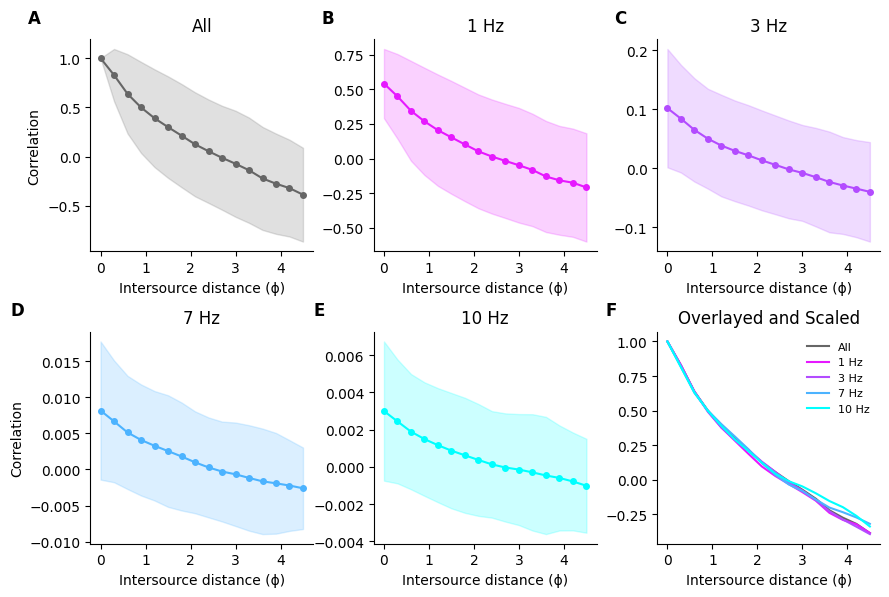

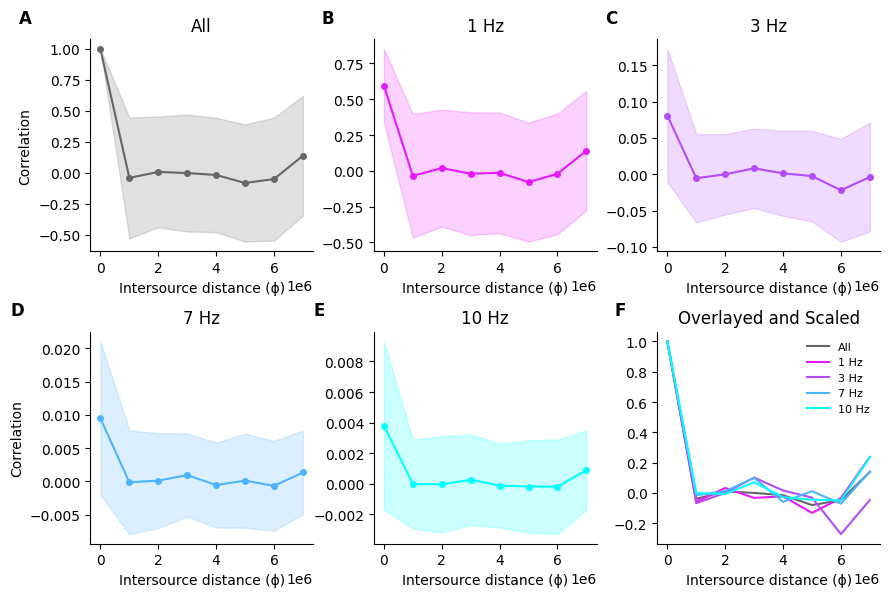

In [33]:
reload(fpf)
which_freqs = [1,3,7,10] * UNITS.hertz
labs = [f"{f}" for f in which_freqs]
cols = {"All":cm.gray(0.4)}; cols.update({l:col for l,col in zip(labs, [cm.cool(1 - f.magnitude/10) for f in which_freqs])})
xlims_  = {"su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
xticks_ = {"su":DEFAULT, "bw":DEFAULT, "cr":DEFAULT}
for k, F in data.items():
    print(k)
    slices = {"All":slice(1,10000)}
    freq_inds = F.freqs2inds(which_freqs)
    print(f"Mapped frequencies {which_freqs} to indices {freq_inds}.")
    slices.update({l:slice(fi, fi+1) for l, fi in zip(labs, freq_inds)})
    ax = fpf.plot_correlations(F.rho[iprb], F.pitch, slices=slices, cols=cols, n_rows = 2, plot_order = ["All"] + labs)
    [(axi.set_xlabel(f"Intersource distance ({fpf.pitch_sym})"),
      not isdefault(xlims_[k])  and axi.set_xlim(xlims_[k]),
      not isdefault(xticks_[k]) and axi.set_xticks(xticks_[k])) for axi in ax]    
    file_name = f"{fig_dir}/corr_components_{k}.pdf"
    fpft.label_axes(ax, "ABCDEF", fontsize=12, fontweight="bold", dy=-0.01)        
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."))

# The Multivariate Gaussian Fits

bw
Mapped 5 Hz to index 5.


su
Mapped 5 Hz to index 5.


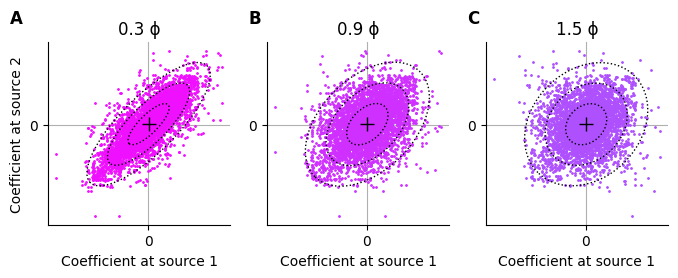

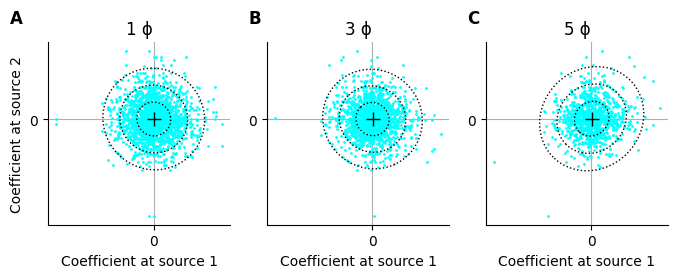

In [34]:
reload(fpf)
which_freqs = {"su":5 * UNITS.hertz,"bw":5 * UNITS.hertz, "cr":5 * UNITS.hertz}
which_idists= {"su":[0,2,4], "bw":[0,2,4], "cr":[8,12,18]}
dcol_scales = {"su":120000,  "bw":120000,  "cr":80000}
for name, F in sorted(data.items()):
    print(name)
    which_freq = which_freqs[name]
    ifreq = F.freqs2inds([which_freq])[0]
    print(f"Mapped {which_freq} to index {ifreq}.")
    ax = fpf.plot_coef1_vs_coef2([F.ss[iprb], F.cc[iprb]],
                                 ifreq,
                                 F.pairs_um,
                                 F.pitch_units,                                 
                            i_pos_dists_to_plot = which_idists[name],
                            dist_col_scale = dcol_scales[name]
    )
    fpft.label_axes(ax, "ABC", fontsize=12, fontweight="bold", dy=-0.01)            
    file_name = f"{fig_dir}/coef_vs_coef_{name}_{which_freq.magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Supplementary Information

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:45: RuntimeWarning: divide by zero encountered in log
  balance = [np.exp(np.abs(np.log(np.abs(x/y)))) for (x,y) in p]


ZeroDivisionError: division by zero

<Figure size 800x300 with 0 Axes>

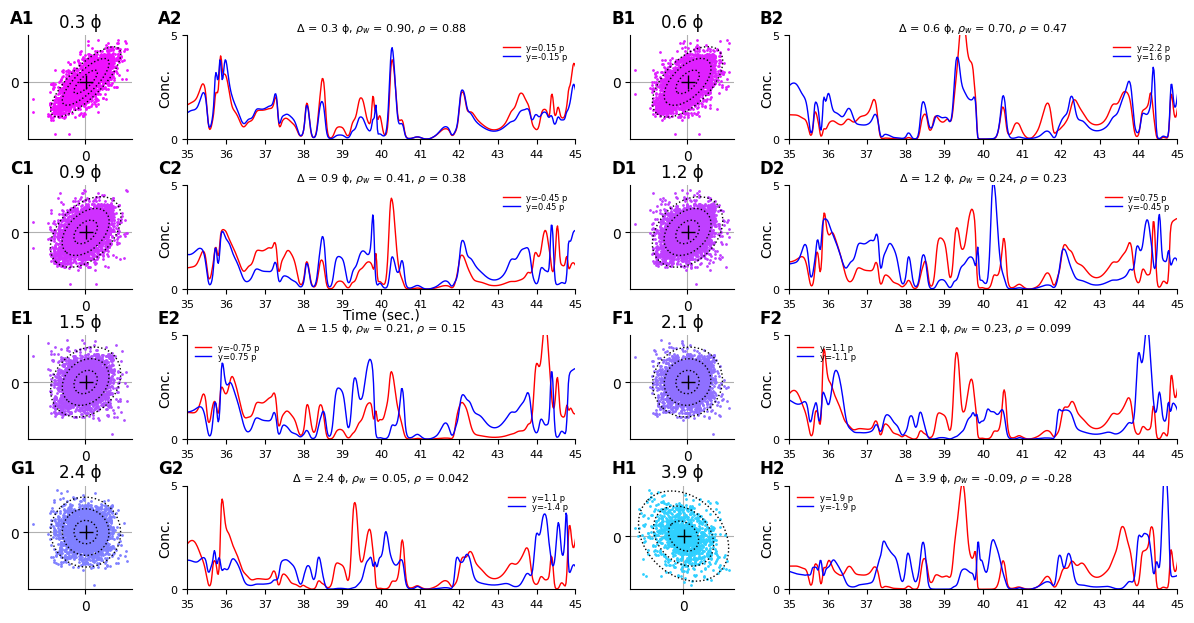

<Figure size 800x300 with 0 Axes>

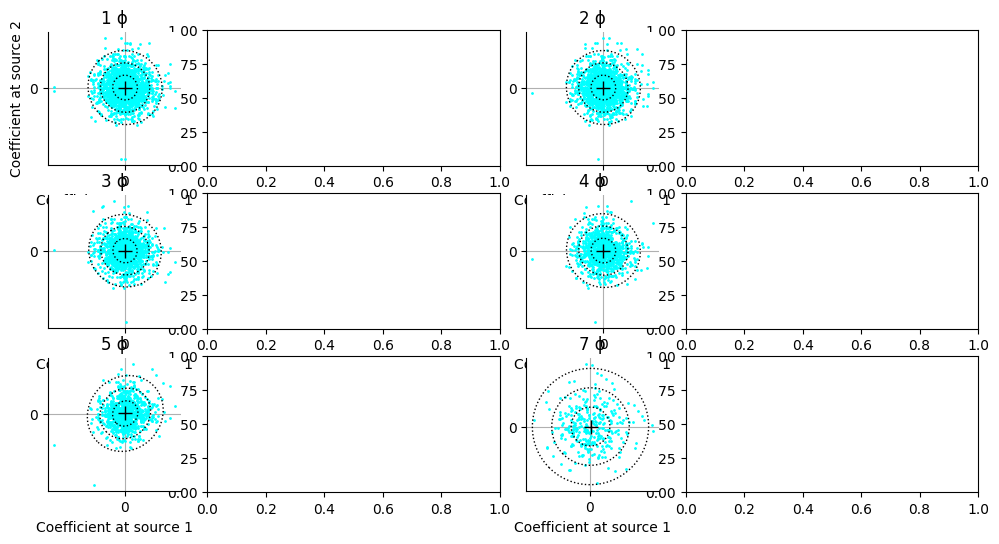

ZeroDivisionError: division by zero

In [36]:
reload(fpf)
reload(fpft)
freq      = {"su":5 * UNITS.hertz,    "bw":5 * UNITS.hertz,          "cr":5 * UNITS.hertz}
idists    = {"su":[0,1,2,3,4,6],      "bw":[0,1,2,3,4,6,7,12],       "cr":[0,4,8,12,16,20,21,22]}
t_lim     = {"su":[35, 45]*UNITS.sec, "bw":[35, 45]*UNITS.sec,       "cr":[39.5,40.5]*UNITS.sec}
dt        = {"su":1*UNITS.sec,        "bw":1*UNITS.sec,              "cr":0.25*UNITS.sec}
for k, F in sorted(data.items()):
    figure(figsize=(12,6))
    coef_ax, trace_ax = fpf.plot_coef_vs_coef_and_traces(F, freq[k], idists[k],
                                                         which_probe = iprb, n_per_row = 2,
                                                         y_lim=[0,5],
                                                         t_lim = t_lim[k],
                                                         dt = dt[k])
    for ax in coef_ax:
        ax.set_xlabel("")
        ax.set_ylabel("")
    [ax.legend(fontsize=6,labelspacing=0,frameon=False) for ax in trace_ax]
    tight_layout(pad=0)
    all_ax = bsum([[ax_c, ax_t] for ax_c, ax_t in zip(coef_ax, trace_ax)], [])
    n_ax   = len(all_ax)
    fpft.label_axes(all_ax,
                    [ch+nu for ch in "ABCDEFGH" for nu in "12"],
                    align_x = [list(range(i,n_ax,4)) for i in range(4)],
                    align_y = [list(range(i,i+4)) for i in range(0,n_ax,4)],
                    fontsize=12, fontweight="bold", dy=-0.01)
    file_name = f"{fig_dir}/coefs_and_traces_{k}_{freq[k].to(UNITS.hertz).magnitude}Hz.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Asymmetric Laplacian Fits

d=7500 @ Freq #   1: -np.log10(p) = 142.277
d=15000 @ Freq #   1: -np.log10(p) = 105.410
d=22500 @ Freq #   1: -np.log10(p) = 75.585
Setting extent to [-0.5, 15.5, 0.5, 20.5].


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


d=7500 @ Freq #   5: -np.log10(p) = 3.393
d=15000 @ Freq #   5: -np.log10(p) = 1.215
d=22500 @ Freq #   5: -np.log10(p) = 1.713
Setting extent to [-0.5, 15.5, 0.5, 20.5].


d=7500 @ Freq #  10: -np.log10(p) = 29.570
d=15000 @ Freq #  10: -np.log10(p) = 12.817
d=22500 @ Freq #  10: -np.log10(p) = 8.230
Setting extent to [-0.5, 15.5, 0.5, 20.5].


d=1000000 @ Freq #   1: -np.log10(p) = 13.820
d=2000000 @ Freq #   1: -np.log10(p) = 7.697
d=3000000 @ Freq #   1: -np.log10(p) = 8.596
Setting extent to [-0.5, 7.5, 0.5, 20.5].


d=1000000 @ Freq #   5: -np.log10(p) = 2.608
d=2000000 @ Freq #   5: -np.log10(p) = 1.863
d=3000000 @ Freq #   5: -np.log10(p) = 5.696
Setting extent to [-0.5, 7.5, 0.5, 20.5].


d=1000000 @ Freq #  10: -np.log10(p) = 0.746
d=2000000 @ Freq #  10: -np.log10(p) = 0.198
d=3000000 @ Freq #  10: -np.log10(p) = 0.598
Setting extent to [-0.5, 7.5, 0.5, 20.5].


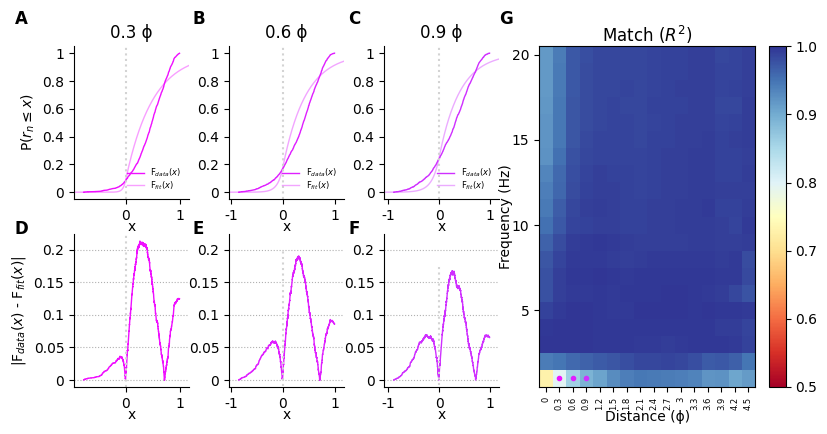

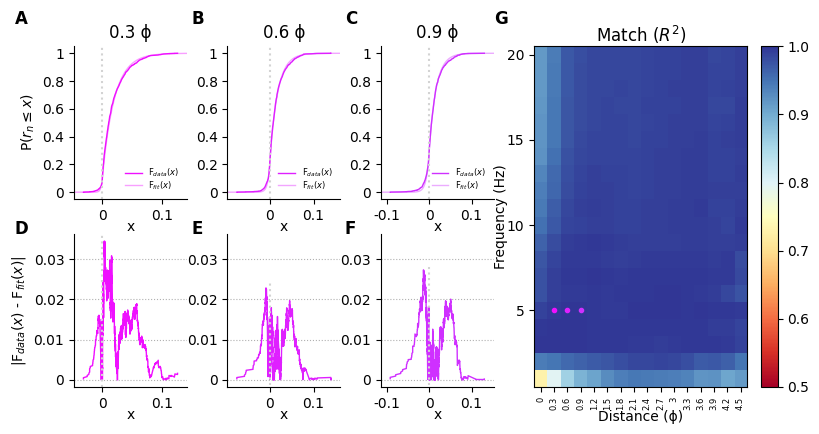

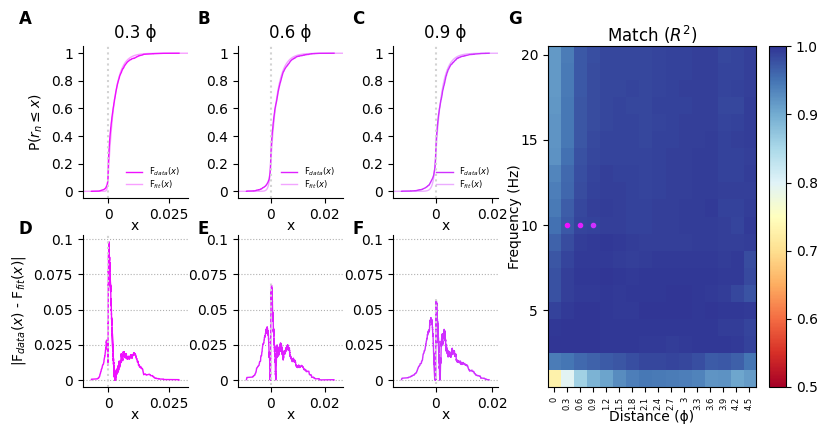

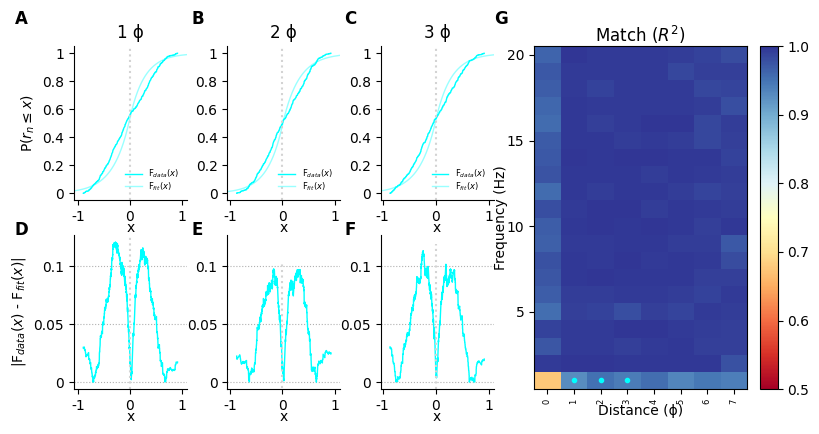

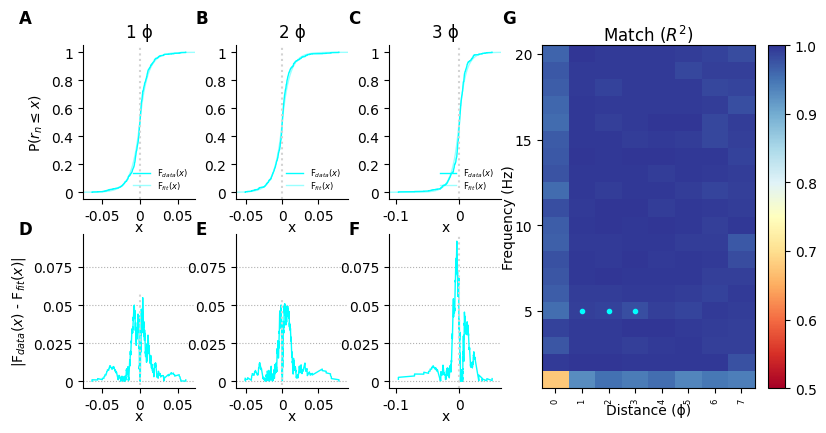

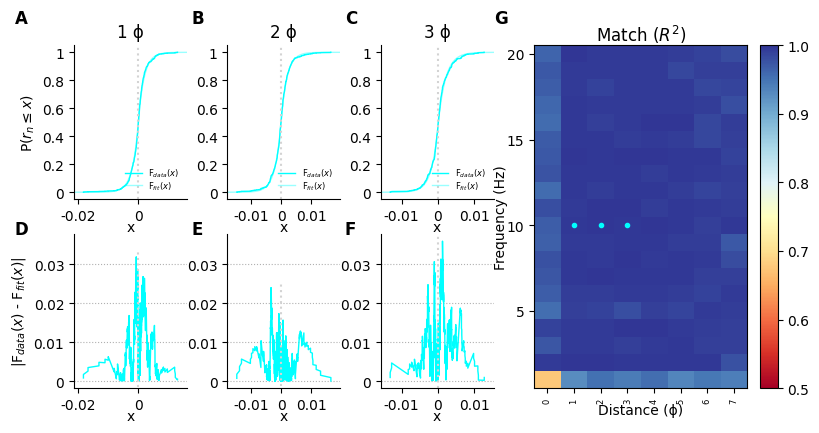

In [38]:
reload(fpft)
reload(fpf)
which_wnd_sec = wnd_sec_vals[0]
idist     = {"su":[1,2,3],          "bw":[1,2,3],       "cr":[1,13,19]}
freq_max  = {"su":21 * UNITS.hertz, "bw":21 * UNITS.hertz,            "cr":101 * UNITS.hertz}
vmin      = {"su":[0,0.5],          "bw":[0,0.5],       "cr":[0,0.5]}
vmax      = {"su":[50,1],           "bw":[50,1],        "cr":[10,1]}
plot_pvals= False
for name, F in sorted(data.items()):
    d = np.array(list(F.rho[iprb].keys()))
    d = np.sort(d[d>=0])
    for f in [1, 5, 10] * UNITS.hertz:
        which_freq = {"su":f, "bw":f, "cr":f}
        ax_cdf, ax_dcdf, ax_hm = fpf.plot_alaplace_fits(F, d[idist[name]],
                                                        which_probe = iprb,
                               ifreq_lim = [1, F.freqs2inds([freq_max[name]])[0]],
                               which_ifreq = F.freqs2inds([which_freq[name]])[0],
                                                        figsize=(8,4),
                                                        vmax=vmax[name],
                                                        vmin=vmin[name],
                                                        plot_dvals=True,
                                                        plot_pvals=plot_pvals)
        tight_layout(pad=0)
        fpft.label_axes(ax_cdf + ax_dcdf + ax_hm, "ABCDEFGHIJK",
                        align_y = [[0,1,2,6],[3,4,5,7]] if plot_pvals else [[0,1,2],[3,4,5]],
                        align_x = [[0,3],[1,4],[2,5]],
                        fontsize=12, fontweight="bold", dy=0)
        file_name = f"{fig_dir}/alap_fits_{name}_{which_freq[name].to(UNITS.hertz).magnitude}Hz.pdf"
        SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the figure showing λ(s)

      fisher_plumes_figs 2023/05/05 06:52:26     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:422: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_xticklabels(f"{10**xti:.2g}" for xti in xt)
/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:428: UserWarning: FixedFormatter should only be used together with FixedLocator
  log_scale and plt.gca().set_yticklabels(f"{10**yti:.2g}" for yti in yt)


      fisher_plumes_figs 2023/05/05 06:52:26     INFO: plot_gen_exp_paramter_fits_panel with which_fis=[1, 3, 7, 10], log_scale=True.


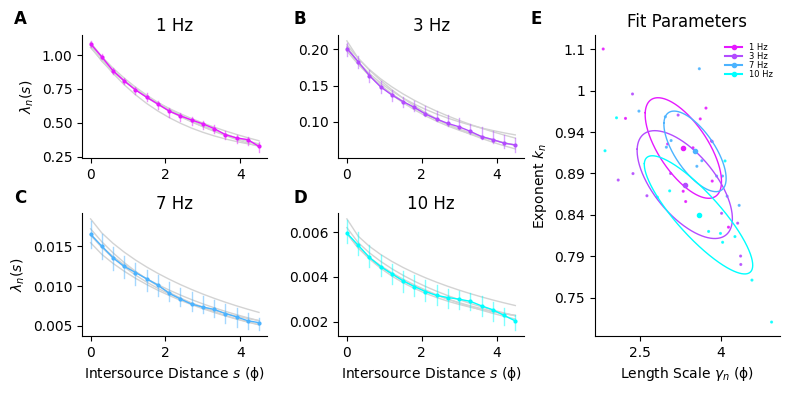

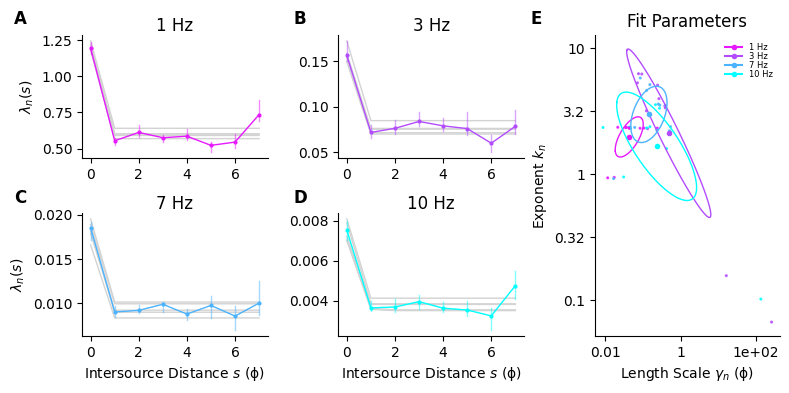

In [39]:
reload(fpft)
reload(fpf)
xl     = {"su":(-10,200),"bw":(-10,200),                 "cr": (-2, 50)}
freqs  = {"su":[1,3,7,10] * UNITS.hertz, "bw":[1,3,7,10] * UNITS.hertz,  "cr": [1,3,7,10] * UNITS.hertz}
xt     = {"su":arange(0,201,50),"bw":arange(0,201,50),          "cr": arange(0,101,25)}
xtp    = {"su":np.array([60,90,135]), "bw":np.array([60,90,135]),     "cr": np.array([40,60, 90, 135])}
ytp    = {"su":np.array([0.8,1,1.2,1.5]),"bw":np.array([0.8,1,1.2,1.5]), "cr": np.array([0.8,1,1.2,1.5,2])}
for k, F in sorted(data.items()):
    ax = fpf.plot_la_gen_fits_vs_distance(F, 
                                          figsize=(8,4), legloc = 'right',
                                          log_scale = True,
                                          scatter_size=1.5,
                                          which_ifreqs = F.freqs2inds(freqs[k]))
    [((i>1) and axi.set_xlabel(f"Intersource Distance $s$ ({fpf.pitch_sym})")) for i, axi in enumerate(ax[:4])]
    tight_layout(h_pad=1,w_pad=0.5)
    fpft.label_axes(ax, "ABCDEFGHIJK",
                    align_y = [[0,1,4],[2,3]],
                    align_x = [[0,2],[1,3]],
                    fontsize=12, fontweight="bold", dy=-0.02)                        
    file_name = f"{fig_dir}/la_vs_s_fits_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Plot the Fisher Information

      fisher_plumes_figs 2023/05/05 06:57:11     INFO: dd[0]=100, dd[-1]=125000 (0.004, 5 ϕ)


      fisher_plumes_figs 2023/05/05 06:57:11     INFO: Plotting which_ifreqs=[1, 2, 5, 10, 20].


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:548: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_fisher.set_xticklabels(ax_fisher.get_xticklabels(), fontsize=8)
/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_figs.py:550: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax_fisher.set_xlim(np.floor(d0/d_scale), np.ceil(d1/d_scale))
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/colors.py:710: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  xa = np.array(X, copy=True)
/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/numpy/ma/core.

      fisher_plumes_figs 2023/05/05 06:57:11     INFO: dd[0]=100, dd[-1]=1e+07 (0.0001, 10 ϕ)


/nemo/lab/schaefera/working/tootoos/git/fisher-plumes/fisher_plumes_tools.py:158: RuntimeWarning: divide by zero encountered in true_divide
  return coef * num1 / den1 / den2
      fisher_plumes_figs 2023/05/05 06:57:11     INFO: Plotting which_ifreqs=[1, 3, 7, 10].


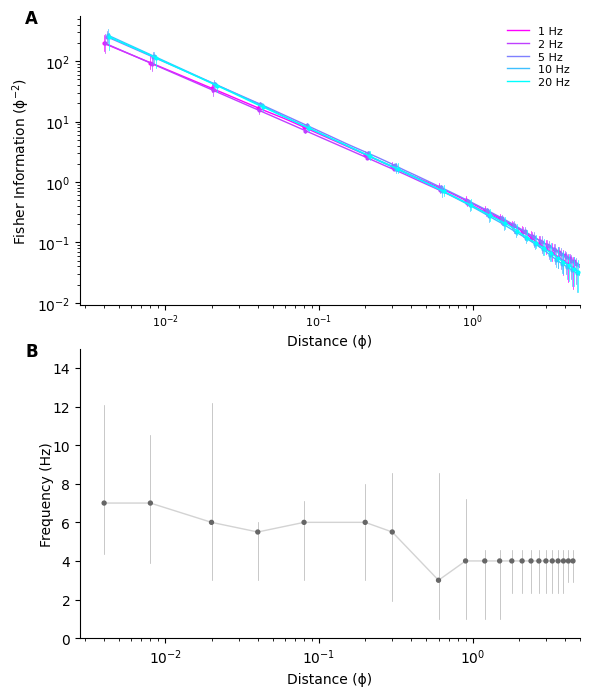

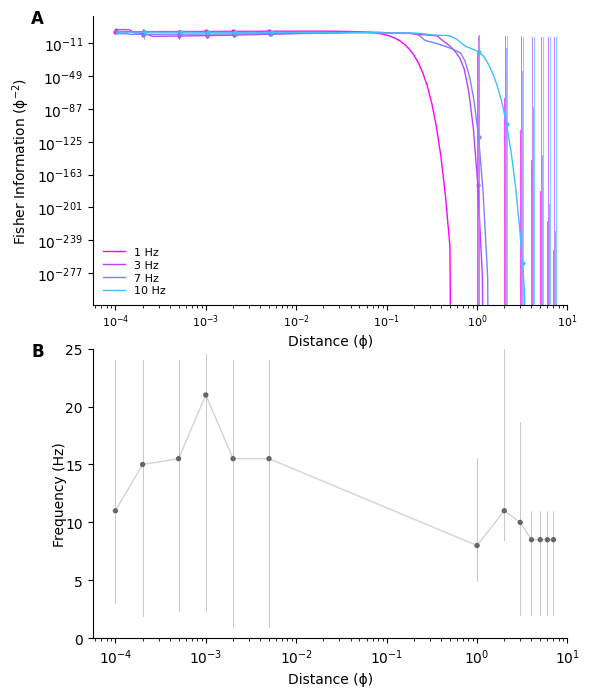

In [46]:
reload(fpt)
reload(fpft)
reload(fpf)
freqs["cr"] = [1,2, 5, 10, 20] * UNITS.hertz
freqs["bw"] = [1,2, 5, 10, 20] * UNITS.hertz
freqs["cr"] = [5,10,20,50,100] * UNITS.hertz
freq_max  = {"su":20 * UNITS.hertz,"bw":20 * UNITS.hertz, "cr":100 * UNITS.hertz}
colscale  = {"su":10, "bw":10, "cr":40}
d_vals_um = {"su":[1,5,50],"bw":[1,5,50], "cr":[0.1,10,70]}
d_lim_um  = {"su":[100, 10**7], "bw":[100, 125000 ], "cr":[100, 125000]}
bf_ytick  = {"su":[0,5,10], "bw":[0,5,10], "cr":[0,50,100]}
bf_yl     = {"su":[0,25],"bw":[0,15], "cr":[-5,100]}
for k, F in sorted(data.items()):
    figure(figsize=(6,7))
    ax_fisher, ax_best_freq, ax_d = fpf.plot_fisher_information(F,
                                                                which_probe = iprb,
                                                                d_lim_um   = d_lim_um[k],
                                                                d_vals_um  = np.array(d_vals_um[k])*1000,
                                                                d_space_fun  = lambda d0,d1,n:np.logspace(log10(d0),log10(d1),n),
                                                                which_ifreqs = F.freqs2inds(freqs[k]),
                                                                x_stagger = lambda x, i: x*(1.02**i),
                                                                fi_scale  = 1, plot_fun = plt.loglog,
                                                                log_scale = True,
                                                                #freq_max  = freq_max[k],
                                                                colfun    = lambda f: cm.cool_r(f/colscale[k]),
                                                                #bf_ytick  = bf_ytick[k],
    )
    tight_layout(h_pad=0,w_pad=0)
    fpft.label_axes([ax_fisher, ax_best_freq] + ax_d , "ABCDEFGHIJK",
                    #align_y = [[2,3,4]],
                    align_x = [[0,1]],
                    fontsize=12, fontweight="bold", dy=-0.01)
    ax_best_freq.set_ylim(bf_yl[k])
    file_name = f"{fig_dir}/fisher_info_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));
    

# Plot best frequency for each probe

/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_2sec/best_freq_bw.pdf.


/camp/home/tootoos/working/tootoos/conda-envs/py38/lib/python3.8/site-packages/matplotlib/cbook/__init__.py:1369: UnitStrippedWarning: The unit of the quantity is stripped when downcasting to ndarray.
  return np.asarray(x, float)


Wrote figs/wnd_2sec/best_freq_cr.pdf.


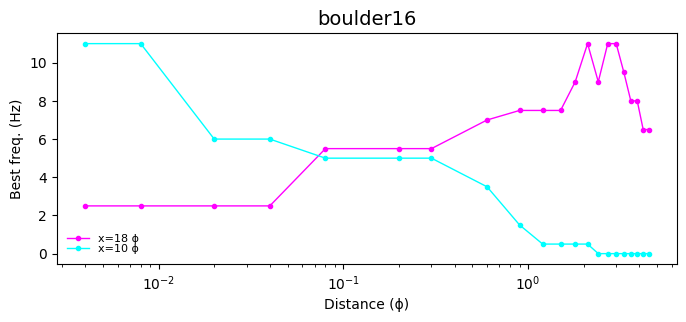

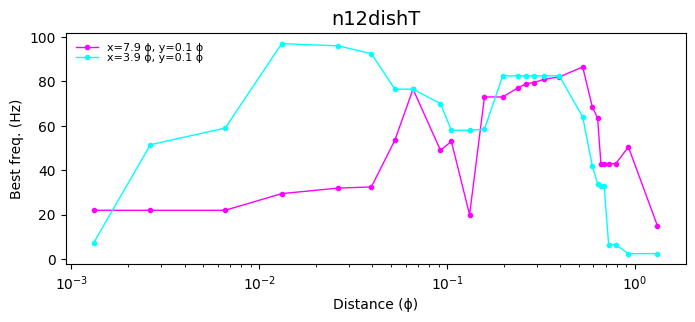

In [22]:
for k, F in sorted(data.items()):
    probe_coords = utils.d1(F.sims).get_used_probe_coords()
    probe_xcoords_sorted = sorted([p[0] for p in probe_coords])
    probe_names = utils.d1(F.sims).coord_strs
    n_probes = len(probe_coords)
    figure(figsize=(8,3))
    dd = F.I_dists/F.pitch.to(UNITS.um).magnitude
    for which_probe, (px,py) in enumerate(probe_coords):
        semilogx(dd, median(F.freqs[F.I_best_ifreqs[which_probe]][1:],axis=0),
                 "o-",markersize=3, linewidth=1, color = cm.cool(probe_xcoords_sorted.index(px)/max((n_probes-1),1)), label=probe_names[which_probe])
    xlabel("Distance (ϕ)")
    ylabel("Best freq. (Hz)")
    title(F.name, fontsize=14)
    legend(frameon=False, labelspacing=0, fontsize=8)
    file_name = f"{fig_dir}/best_freq_{k}.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));
        


# Plot the Power in each Signal

Wrote figs/wnd_1sec/spectra.pdf.


Wrote figs/wnd_2sec/spectra.pdf.


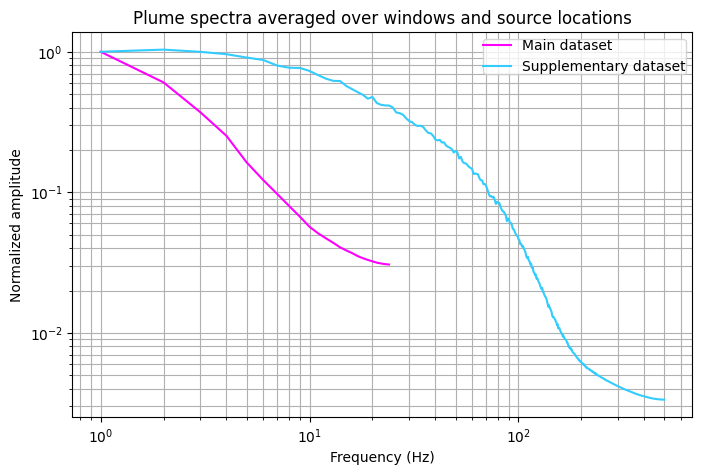

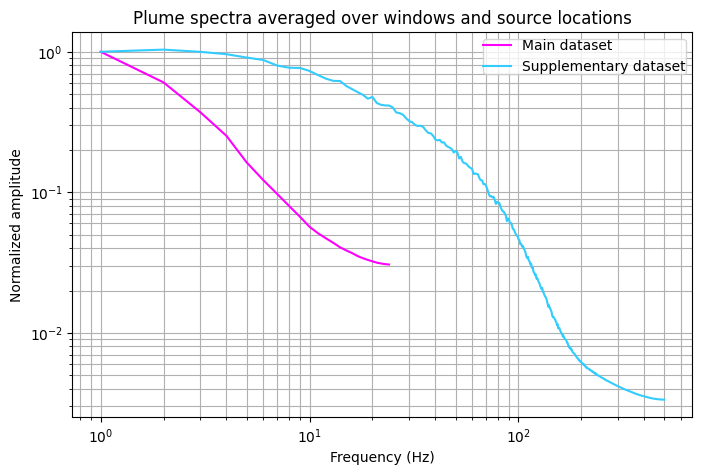

In [23]:
for wnd_in_sec, dataw in data_wnd.items():
    figure(figsize=(8,5))
    for k, F in sorted(dataw.items()):
        f = []
        for _, s in F.sims.items():
            fs = F.fs.to(UNITS.hertz).magnitude
            fr, ti, S = stft(s.data[:,iprb], fs = fs, window='boxcar',
                             nperseg=int(fs), noverlap=fs//2, boundary=None, padded=False)
            f.append(np.abs(S))
            
        f = np.array(f)
        a = np.mean(f,axis=-1).mean(axis=0)    
        loglog(fr[fr<fs/2][1:],a[fr<fs/2][1:]/a[1], label="Supplementary dataset" if k=="cr" else "Main dataset", color={"bw":cm.cool_r(0.0), "cr":cm.cool_r(0.8)}[k])
    legend(borderpad=0)
    xlabel("Frequency (Hz)")
    ylabel("Normalized amplitude")
    title("Plume spectra averaged over windows and source locations")
    grid(True, which='both')
    file_name = f"{fig_dir_fun(wnd_in_sec)}/spectra.pdf"
    SAVEPLOTS and (savefig(file_name, bbox_inches='tight'), print(f"Wrote {file_name}."));

# Sandbox

In [22]:
F, f_max  = data["bw"], 7
f         = F.freqs.magnitude
ind_freqs = where((f>0) & (f<=f_max))[0]
I         = F.I[0]
If        = einsum('ijk,j',I[:,ind_freqs],f[ind_freqs])
Isum      = sum(I[:,ind_freqs],axis=1)
Iw        = If/Isum
p = percentile(Iw[1:],[5,50,95],axis=0)

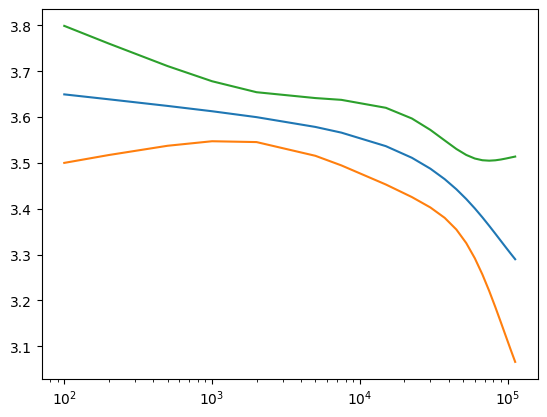

In [23]:
m = mean(Iw[1:],axis=0)
s = std(Iw[1:],axis=0)

semilogx(F.I_dists, m)
semilogx(F.I_dists, m-s)
semilogx(F.I_dists, m+s)
